SELECT s.station_gu, s.station_id, 

ROUND(ST_Distance_Sphere(POINT(station_longitude, station_latitude),POINT({lng}, {lat})), 1) as 거리


FROM station s, rental_daily_stataion r
WHERE s.station_name = r.station_id

- iterrows For 문으로 station 좌표 돌리고
- 각 좌표마다 station 테이블내 대여소들과 거리 재서 제일 가까운거 얻는데 
    - 탐색하는 station ID 와, 제 2의 ID 가 같지 않아야 하고
- LIMIT 1 로 가까운거 거리 얻고
- distance_list = [] 에 집어 넣어서
- 기존 station 테이블에 컬럼 새로 만들고 Insert 

# 탐색하고자 하는 대여소 불러오기

In [29]:
import mysql.connector


remote = mysql.connector.connect (
    host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "root",
    password = "jinhyuk2dacibul",
    database = "project1"
)

cursor = remote.cursor(buffered=True)
cursor.execute(f"""SELECT *\
               FROM station\
               """)

result = cursor.fetchall()

remote.close()

### df_station 생성

In [30]:
import pandas as pd

df_station = pd.DataFrame(result, columns = ['대여소ID', '자치구', '위도', '경도', '고도(m)', '동'], )
# df_station.drop(['대여날', '날씨날'], axis=1, inplace=True)
df_station

,대여소ID,자치구,위도,경도,고도(m),동
0,ST-10,마포구,37.552746,126.918617,15.0,서교동
1,ST-100,광진구,37.536667,127.073593,15.0,자양동
2,ST-1000,양천구,37.510380,126.866798,10.0,신정동
3,ST-1001,양천구,37.529706,126.832446,20.0,신월동
4,ST-1002,양천구,37.529900,126.876541,10.0,목동
...,...,...,...,...,...,...
3294,ST-995,양천구,37.510597,126.857323,25.0,신정동
3295,ST-996,양천구,37.524334,126.850548,30.0,신월동
3296,ST-997,양천구,37.534390,126.869598,10.0,목동
3297,ST-998,양천구,37.531931,126.871591,10.0,목동


# 매 대여소마다 인접 대여소와 거리 구하는 공식

In [21]:
import mysql.connector
from tqdm import tqdm

remote = mysql.connector.connect (
        host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
        port = 3306,
        user = "root",
        password = "jinhyuk2dacibul",
        database = "project1"
    )

cursor = remote.cursor(buffered=True)

limit = 1
distances = []

for i,row in tqdm(df_station.iterrows(), total=len(df_station)):    

    id = row['대여소ID']
    lat = row['위도']
    lng = row['경도']

    # 조건 - 기준 대여소와 탐색 대여소가 겹치면 거리가 당연히 0 이 되니, 겹치지 않아야 함!
    cursor.execute(f"""SELECT station_gu, station_id,
                            ROUND(ST_Distance_Sphere(POINT(station_longitude, station_latitude), POINT({lng}, {lat})), 1) as 거리
                        FROM station
                        WHERE station_id != "{id}"
                        ORDER BY 거리
                        LIMIT {limit}""")

    result = cursor.fetchall()
    # print(result)

    distance = result[0][2]
    distances.append(distance)

distances

100%|██████████| 3299/3299 [01:01<00:00, 53.50it/s]


[379.5,
 284.2,
 250.8,
 104.2,
 137.9,
 54.2,
 200.1,
 168.6,
 278.1,
 264.7,
 243.6,
 153.4,
 12.0,
 153.4,
 53.5,
 149.8,
 87.3,
 159.3,
 81.6,
 188.1,
 282.7,
 263.5,
 246.7,
 56.7,
 159.1,
 84.0,
 261.8,
 112.6,
 272.5,
 56.1,
 41.6,
 169.4,
 112.6,
 467.1,
 247.8,
 70.5,
 239.1,
 154.7,
 255.0,
 253.2,
 291.9,
 186.1,
 77.5,
 79.2,
 341.6,
 68.3,
 306.1,
 154.4,
 194.6,
 214.5,
 164.9,
 194.6,
 403.7,
 191.9,
 202.8,
 55.6,
 67.8,
 65.4,
 66.2,
 42.8,
 84.9,
 361.1,
 122.2,
 62.3,
 114.9,
 29.4,
 89.0,
 82.3,
 27.8,
 283.4,
 66.7,
 69.2,
 139.2,
 55.7,
 174.2,
 139.7,
 96.1,
 168.9,
 233.7,
 126.9,
 113.6,
 248.0,
 156.2,
 260.1,
 57.3,
 182.2,
 154.7,
 143.8,
 159.1,
 297.5,
 192.3,
 235.4,
 60.5,
 284.5,
 174.0,
 196.5,
 280.4,
 52.9,
 32.2,
 112.2,
 132.4,
 355.6,
 61.5,
 139.5,
 92.4,
 147.3,
 152.8,
 188.7,
 56.9,
 39.6,
 117.6,
 214.7,
 86.7,
 11.7,
 148.5,
 362.9,
 550.5,
 251.5,
 339.3,
 143.8,
 49.4,
 149.1,
 279.8,
 452.9,
 142.9,
 47.8,
 145.5,
 152.5,
 106.2,
 217.6,


# df_station 에 최소거리까지 포함 

In [31]:
df_station['최소거리(m)'] = distances
df_station

,대여소ID,자치구,위도,경도,고도(m),동,최소거리(m)
0,ST-10,마포구,37.552746,126.918617,15.0,서교동,379.5
1,ST-100,광진구,37.536667,127.073593,15.0,자양동,284.2
2,ST-1000,양천구,37.510380,126.866798,10.0,신정동,250.8
3,ST-1001,양천구,37.529706,126.832446,20.0,신월동,104.2
4,ST-1002,양천구,37.529900,126.876541,10.0,목동,137.9
...,...,...,...,...,...,...,...
3294,ST-995,양천구,37.510597,126.857323,25.0,신정동,162.3
3295,ST-996,양천구,37.524334,126.850548,30.0,신월동,261.0
3296,ST-997,양천구,37.534390,126.869598,10.0,목동,219.2
3297,ST-998,양천구,37.531931,126.871591,10.0,목동,261.4


# DB Table (station_gap_distances) 만들기

In [25]:
import mysql.connector

remote = mysql.connector.connect(
    host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "root",
    password = "jinhyuk2dacibul",
    database = "project1"
)

cursor = remote.cursor(buffered=True)

cursor.execute("""CREATE TABLE station_gap_distances \
               (station_id VARCHAR(10) NOT NULL PRIMARY KEY, \
               min_gap_distance FLOAT)""")

remote.commit()
remote.close()

# DB (station_gap_distances)에 집어 넣기

In [26]:
import mysql.connector
from tqdm import tqdm

remote = mysql.connector.connect (
    host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "root",
    password = "jinhyuk2dacibul",
    database = "project1"
)

cursor = remote.cursor(buffered=True)

sql= """INSERT INTO station_gap_distances VALUES (%s, %s)"""

for i, row in tqdm(df_station.iterrows(), total=len(df_station)): 

    id = row['대여소ID']
    dist = row['최소거리']

    cursor.execute(sql, (id, dist))

    # print(id, date, count)

    
remote.commit()
remote.close()

100%|██████████| 3299/3299 [00:36<00:00, 90.47it/s] 


# DB에서 '대여소별' 일일 대여량 & 고도 불러오기

In [32]:
import mysql.connector

remote = mysql.connector.connect (
    host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "root",
    password = "jinhyuk2dacibul",
    database = "project1"
)

cursor = remote.cursor(buffered=True)
cursor.execute(f"""SELECT station_id, cnt, min_gap_distance
                    FROM station_gap_distances s, (SELECT rental_station_id, AVG(rental_count) cnt
                                                    FROM rental_daily_station
                                                    GROUP BY rental_station_id) r
                    WHERE station_id = rental_station_id;""")

result_min_dist = cursor.fetchall()

remote.close()

# df_min_dist 만들기

In [34]:
import pandas as pd

df_min_dist = pd.DataFrame(result_min_dist, columns = ['대여소ID', '평균대여량', '최소거리(m)'])
# df_station.drop(['대여날', '날씨날'], axis=1, inplace=True)

df_min_dist['평균대여량'] = round(df_min_dist['평균대여량'],1).astype(dtype=int)
df_min_dist['최소거리(m)'] = df_min_dist['최소거리(m)'].astype(dtype=int)

df_min_dist

,대여소ID,평균대여량,최소거리(m)
0,ST-10,54,379
1,ST-1000,63,250
2,ST-1002,112,137
3,ST-1003,32,54
4,ST-1004,20,200
...,...,...,...
2769,ST-993,44,175
2770,ST-994,76,92
2771,ST-995,9,162
2772,ST-996,10,261


# 시각화

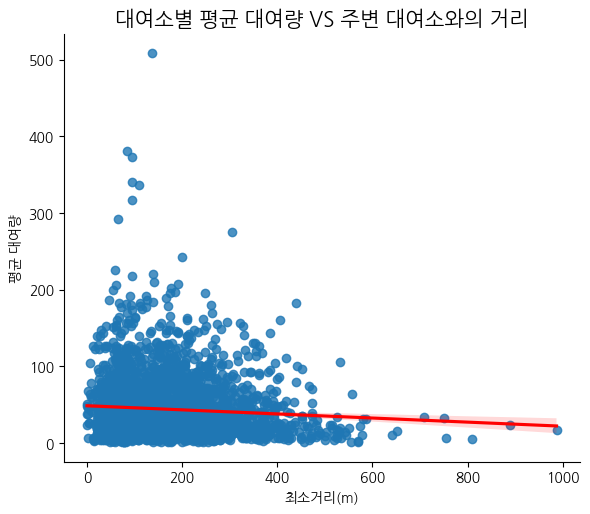

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# tmp = df_min_dist[df_min_dist['고도'] != 0.0]

sns.lmplot(x='최소거리(m)' , y='평균대여량', data = df_min_dist, aspect=1.2, markers= 'o', line_kws={'color': 'red'}, legend=True)
plt.title('대여소별 평균 대여량 VS 주변 대여소와의 거리', fontsize=15)
plt.xlabel('최소거리(m)')
plt.ylabel('평균 대여량')
plt.show()

별다른 인사이트를 얻을 수 없다

### 전 대여소들의 평균 최소 간격 = 170m

In [42]:
df_min_dist['최소거리(m)'].mean()

np.float64(169.6423936553713)

# DB에서 '고도별' 평균 대여량 불러오기

In [ ]:
import mysql.connector

remote = mysql.connector.connect (
    host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "root",
    password = "jinhyuk2dacibul",
    database = "project1"
)

cursor = remote.cursor(buffered=True)
cursor.execute(f"""SELECT station_id, cnt, min_gap_distance
                    FROM station_gap_distances s, (SELECT rental_station_id, AVG(rental_count) cnt
                                                    FROM rental_daily_station
                                                    GROUP BY rental_station_id) r
                    WHERE station_id = rental_station_id;""")

result_dist_avg = cursor.fetchall()

remote.close()

- 먼저 bin 으로 각각의 최소거리를 나누고
- 고도별 평균 cnt 값을 나뉘어야 하는데, 어떻게?

In [ ]:
y_axis = df_min_dist['평균대여량']
x_axis = df_min_dist['고도(m)']

plt.grid
plt.figure(figsize=(5,3))
plt.plot(x_axis, y_axis, color = "gray", linestyle="dashed", linewidth=3, marker='o', markerfacecolor='black', markersize= 8, label='평균값/고도')
plt.legend()
plt.xlabel("고도(m)")
plt.ylabel("평균 대여량")
plt.title("고도별 평균 대여량", fontsize= 15)
plt.show()